# 2. Modelling & Evaluation

## 2.1 Import

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from yellowbrick.target import ClassBalance

from imblearn.over_sampling import SMOTE

In [15]:
data_tf_outlier = pd.read_csv("../data/processed/data_tf_outlier.csv")

## 2.2 Split Training & Testing

In [16]:
target = "level"
features = [i for i in data_tf_outlier.columns if i not in [target, "geometry"]] #store all features name 

y = data_tf_outlier[target]
X = data_tf_outlier[features]

In [17]:
# Split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 42)

In [18]:
# Dataset with outliers
print("Original dataset :", X.shape, y.shape)
print("Training dataset :", X_train.shape, y_train.shape)
print("Testing dataset  :", X_test.shape,"", y_test.shape)

Original dataset : (100529, 8) (100529,)
Training dataset : (60317, 8) (60317,)
Testing dataset  : (40212, 8)  (40212,)


## 2.3 Create Function

In [19]:
# Change font size for ticks
def bigger_ticks_font_size(ax):
    ax.tick_params(axis = "x", labelsize = 13)
    ax.tick_params(axis = "y", labelsize = 13)

# Change font size for labels
def bigger_label_font_size(ax, xlabel_name, ylabel_name):
    ax.set_xlabel(xlabel_name, fontsize = 16)
    ax.set_ylabel(ylabel_name, fontsize = 16)

# Create a new color palette consisted of the extracted hex codes from Set2 palette and other additional colors
palette = ["#fc8d62", "#ffd92f", "#e5c494", "#b3b3b3", "#66c2a5", "#96b9d0", "#8da0cb", "#ce94bc", "#eba7ac", "#f5ae52"]

In [20]:
# Function to do prediction for each training and testing test
def PredictData(model, X_train, X_test):
    return {
        "y_train": model.predict(X_train),  # Prediction with training dataset
        "y_test": model.predict(X_test),
    }

In [21]:
# Function to evaluate model 
def EvaluateModel(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    nrmse = rmse/np.std(y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "NRMSE": nrmse,
        "R2_Score": r2,
    }

In [22]:
# Evaluation Metric Comparison for different Regression Models
def PlotMetric (eval_train, eval_test, metric, idx, top_result, model_title, figsize, legend_coor, float_limit):

    fig, ax = plt.subplots(figsize = figsize)
    # Store evaluation result for each training and testing set
    eval_train = eval_train[metric]
    eval_test  = eval_test[metric]

    # If it's R2_Score sort with the highest value first, if not (which means it's error rate) sort with the lowest value first
    ascending_val       = np.where(metric == "R2_Score", False, True)
    eval_train_sorted   = eval_train.sort_values(ascending = bool(ascending_val))
    eval_test_sorted    = eval_test.sort_values(ascending = bool(ascending_val))
    
    # Default value for lineweight, dot size, and fontweight
    lw_train    = np.full((len(eval_train)), 1)
    lw_test     = np.full((len(eval_train)), 1)
    size_train  = np.full((len(eval_train)), 50)
    size_test   = np.full((len(eval_train)), 50)  
    fw_train    = ["normal"]*len(eval_train)
    fw_test     = ["normal"]*len(eval_train)

    # Make linewidth, dot size, and fontweight stand out for 3 top metric scores (lowest error/highest performance)
    for x in range(len(eval_train)):
        for n in range(top_result):
            if(eval_train[x] == eval_train_sorted[n]): #If value is the best score(at n-th index of sorted values)
                lw_train[x] = 3; size_train[x] = 160; fw_train[x] = "semibold"
            if(eval_test[x] == eval_test_sorted[n]):
                lw_test[x] = 3; size_test[x] = 160; fw_test[x] = "semibold"

    # Function to keep the line and dot inside the plot if the score is <0 or >100 
    def FindXCoor(eval_data):
        return np.where(((eval_data.values*100) > 100), 1.03,
               np.where(((eval_data.values*100) < 0), 0, eval_data.values))
    # Store the custom x coordinates for each dataset           
    x_coor_test = FindXCoor(eval_test)
    x_coor_train = FindXCoor(eval_train)    

    # Plot horizontal lines
    plt.hlines(y = np.arange(len(eval_test.index))+0.2, xmin = 0, xmax = x_coor_test, color = palette[0], alpha = 0.5, linewidth = lw_test)
    plt.hlines(y = np.arange(len(eval_train.index))-0.2, xmin = 0, xmax = x_coor_train, color = palette[5], alpha = 0.5, linewidth = lw_train)

    # Plot dots   
    ax.scatter(x = x_coor_test, y = np.arange(len(eval_test.index))+0.2, color = palette[0], s = size_test, alpha = 1, label = "Test Data")
    ax.scatter(x = x_coor_train, y = np.arange(len(eval_test.index))-0.2, color = palette[5], s = size_train, alpha = 1, label = "Training Data")

    # Plot text (percentage)
    for i, v in enumerate(eval_test):
        plt.text(x_coor_test[i] + 0.05, i+0.15, str("{:.{}f}%".format(v*100, float_limit)), color="black", fontsize = 12, fontweight = fw_test[i])
    for i, v in enumerate(eval_train):
        plt.text(x_coor_train[i] +0.05, i-0.25, str("{:.{}f}%".format(v*100, float_limit)), color="black", fontsize = 12, fontweight = fw_train[i])
    
    ax.set_yticks(np.arange(len(eval_test.index)))
    ax.set_yticklabels(np.array(idx))
    ax.set_xlim([0, 1]) # Set x-axis limit from 0 to 1
    ax.set_title("{} for {}".format(metric, model_title), fontsize = 20)
    bigger_ticks_font_size(ax)
    bigger_label_font_size(ax, metric, None)
    handles, labels = ax.get_legend_handles_labels() # Get legend handle for figure (so it can be located outside the plot)
    fig.legend(handles, labels, bbox_to_anchor = legend_coor, bbox_transform = ax.transAxes, title = "Dataset") # Set Legend 
    plt.show()

In [23]:
def ScaleData (scaler, X_train, X_test, y_train, y_test, col_names):
    
    # Standardize the features 
    X_train = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train, columns= col_names)
    X_test = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test, columns= col_names)

    # Standardize the target
    y_train = scaler.fit_transform(y_train.values.reshape(-1,1)) # Reshape it into 2D array so it can be processed
    y_test  = scaler.transform(y_test.values.reshape(-1,1))

    dataset = {"X_train" : X_train,
               "X_test"  : X_test,
               "y_train" : y_train,
               "y_test"  : y_test}

    return dataset

In [24]:
def DescribeNumpyArray(arr):
    # measures of central tendency
    mean = np.mean(arr)
    median = np.median(arr)
    
    # measures of dispersion
    min = np.amin(arr)
    max = np.amax(arr)
    range = np.ptp(arr)
    variance = np.var(arr)
    sd = np.std(arr)
    
    print("Descriptive analysis")
    print("Array =", arr)
    print("____________________________")
    print("Measures of Central Tendency")
    print("Mean =", mean)
    print("Median =", median)
    print("____________________________")
    print("Measures of Dispersion")
    print("Minimum =", min)
    print("Maximum =", max)
    print("Range =", range)
    print("Variance =", variance)
    print("Standard Deviation =", sd)

## 2.4 Preparation into Modelling

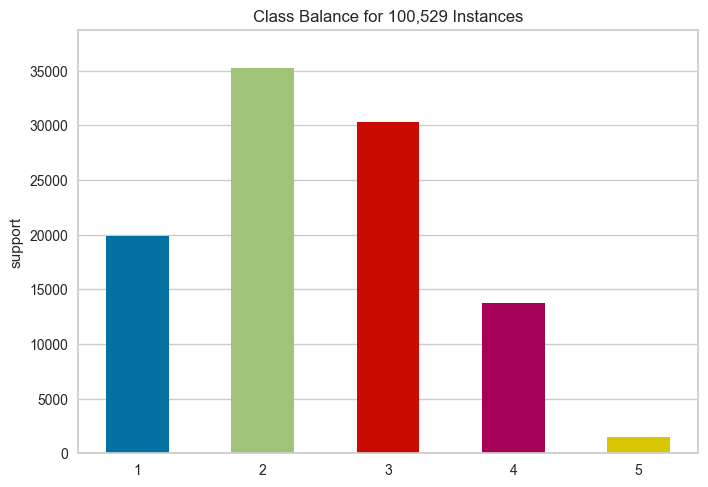

<AxesSubplot: title={'center': 'Class Balance for 100,529 Instances'}, ylabel='support'>

In [25]:
target_proportion = ClassBalance()
target_proportion.fit(y)
target_proportion.show()

In [26]:
sm = SMOTE(random_state=1)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

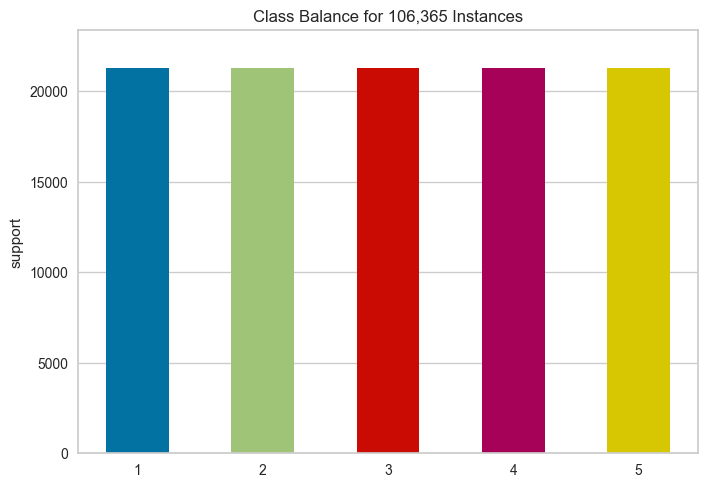

<AxesSubplot: title={'center': 'Class Balance for 106,365 Instances'}, ylabel='support'>

In [27]:
target_proportion = ClassBalance()
target_proportion.fit(y_train_resampled)
target_proportion.show()